In [1]:
import pandas as pd
import numpy as np
import nltk 
import string
import re
import unicodedata
import tweepy
import datetime
from tweepy import OAuthHandler
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from nltk.corpus import words

import spacy

import gensim
from gensim import corpora
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
from gensim.models.phrases import Phrases, Phraser

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Define la ruta del archivo xlsx
ruta_archivo = "Data Science Twitter list.xlsx"

# Carga el archivo xlsx en un DataFrame de Pandas
df = pd.read_excel(ruta_archivo,sheet_name="Population")

In [2]:
df.head()

,Name,Twitter Account,Body,Party,State,Sample
0,Scott Wilk (R),@ScottWilkCA,Senate,(R),CA,Scott Wilk (R)
1,Scott D. Wiener (D),@Scott_Wiener,Senate,(D),CA,Scott D. Wiener (D)
2,Aisha Wahab (D),@aishabbwahab,Senate,(D),CA,NaN
3,Thomas J. Umberg (D),@SenatorUmberg,Senate,(D),CA,NaN
4,Henry I. Stern (D),@HenrySternCA,Senate,(D),CA,NaN


In [7]:
df = df.loc[~df['Body'].str.contains('Executive', na=False)]
df

,Name,Twitter Account,Body,Party,State,Sample
0,Scott Wilk (R),@ScottWilkCA,Senate,(R),CA,Scott Wilk (R)
1,Scott D. Wiener (D),@Scott_Wiener,Senate,(D),CA,Scott D. Wiener (D)
2,Aisha Wahab (D),@aishabbwahab,Senate,(D),CA,NaN
3,Thomas J. Umberg (D),@SenatorUmberg,Senate,(D),CA,NaN
4,Henry I. Stern (D),@HenrySternCA,Senate,(D),CA,NaN
...,...,...,...,...,...,...
274,"Waldron, Katherine",NaN,House of Representatives,(D),FL,NaN
275,"Williams, Patricia H.",NaN,House of Representatives,(D),FL,"Williams, Patricia H."
276,"Woodson, Marie Paule",NaN,House of Representatives,(D),FL,"Woodson, Marie Paule"
277,"Yarkosky, Taylor Michael",NaN,House of Representatives,(R),FL,NaN


## Sampling

In [4]:
# Florida
filtered_df_FL_De = df.loc[(df['State'] == 'FL') & (df['Party'] == '(D)')]
filtered_df_FL_Re = df.loc[(df['State'] == 'FL') & (df['Party'] == '(R)')]

#California
filtered_df_CA_De = df.loc[(df['State'] == 'CA') & (df['Party'] == '(D)')]
filtered_df_CA_Re = df.loc[(df['State'] == 'CA') & (df['Party'] == '(R)')]

In [124]:
# Sample each data frame by taking a maximum of 32 rows from each, 159*20% = 32 
#Florida
sampled_filtered_df_FL_De = filtered_df_FL_De.groupby('Party').apply(lambda x: x.sample(n=min(16, x.shape[0]), random_state=1))
sampled_filtered_df_FL_Re = filtered_df_FL_Re.groupby('Party').apply(lambda x: x.sample(n=min(16, x.shape[0]), random_state=1))

# Sample each data frame by taking a maximum of 24 rows from each, 120*20% = 24
#California
sampled_filtered_df_CA_De = filtered_df_CA_De.groupby('Party').apply(lambda x: x.sample(n=min(12, x.shape[0]), random_state=1))
sampled_filtered_df_CA_Re = filtered_df_CA_Re.groupby('Party').apply(lambda x: x.sample(n=min(12, x.shape[0]), random_state=1))


In [140]:
FL = pd.concat([sampled_filtered_df_FL_De, sampled_filtered_df_FL_Re], axis=0)
CA = pd.concat([sampled_filtered_df_CA_De, sampled_filtered_df_CA_Re], axis=0)

In [126]:
FL.to_excel('FL.xlsx', index=False)

In [127]:
CA.to_excel('CA.xlsx', index=False)

## Twitter

In [5]:
import tweepy
import pandas as pd
consumer_key = "uN2XFHGqnKNHmRWFJZ37GeS6x" #api key 
consumer_secret = "ejPqiggjjrJJJYj5IfshmDgXmz7b5rpeZg9LZej8PwIKW9Iu7k" #API Key Secret

access_token = "1651565590451036161-8oDlgWdhf4oFzFtRcAlE7Ox4NC9vpM"
access_token_secret = "gBa5MgDlKi4Q7Sob6pKuJqALpfWISex60zjJb5JKR7XqH"

In [6]:
# Creating the authentication object
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
# Setting your access token and secret
auth.set_access_token(access_token, access_token_secret)
# Creating the API object while passing in auth information
api = tweepy.API(auth) 

### Filtered by names and date

In [29]:
from datetime import datetime, timedelta, date

# The Twitter user who we want to get tweets from
usernames = ["Scott_Wiener", "Portantino", "JoshNewmanCA", "SenatorMenjivar", "CASenCaballero", "Cblakespear", "AsmMikeFong", "AsmCarrillo",
             "AsmJuanCarrillo","asmtasha", "BenAllenCA", "SenToniAtkins", "ScottWilkCA", "JimPatterson559", "Patterdude", "devonjmathis", 
             "TomLackey36", "joshua_hoover", "billessayli", "AsmMeganDahle", "ShannonGroveCA", "SenJanetNguyen", "SenRogerNiello", "rosilicie"]
# Number of tweets to pull
tweetCount = 1500 #limited number by API

# Fechas de inicio y fin del rango de búsqueda
start_date = datetime(2023, 4, 30).date()
end_date = datetime(2022, 4, 30).date()

# Calling the user_timeline function with our parameters
results = api.user_timeline(id=usernames, count=tweetCount)

# Create a list of dictionaries to store the tweets
tweets = []
for username in usernames:
    results = api.user_timeline(id=username, count=tweetCount)
    for tweet in results:
        tweet_date = tweet.created_at.date()
        if end_date <= tweet_date <= start_date:
            tweet_dict = {"text": tweet.text,
                          "created_at": tweet_date,
                          "user_name": tweet.user.name,
                          "favorite_count": tweet.favorite_count}
            tweets.append(tweet_dict)


# Convert the list of tweets to a Pandas DataFrame
df = pd.DataFrame(tweets, columns=["user_name", "text", "created_at", "favorite_count"])
df

Unexpected parameter: id
Unexpected parameter: id
Unexpected parameter: id
Unexpected parameter: id
Unexpected parameter: id
Unexpected parameter: id
Unexpected parameter: id
Unexpected parameter: id
Unexpected parameter: id
Unexpected parameter: id
Unexpected parameter: id
Unexpected parameter: id
Unexpected parameter: id
Unexpected parameter: id
Unexpected parameter: id
Unexpected parameter: id
Unexpected parameter: id
Unexpected parameter: id
Unexpected parameter: id
Unexpected parameter: id
Unexpected parameter: id
Unexpected parameter: id
Unexpected parameter: id
Unexpected parameter: id
Unexpected parameter: id


,user_name,text,created_at,favorite_count
0,Senator Scott Wiener,#GoldBlooded forever,2023-04-30,37
1,Senator Scott Wiener,I had the honor of awarding @SpeakerPelosi the...,2023-04-30,128
2,Senator Scott Wiener,National ban on assault weapons. Now.,2023-04-30,203
3,Senator Scott Wiener,Trip #6 on Muni today for community events — t...,2023-04-30,190
4,Senator Scott Wiener,"RT @Esqueer_: Happening now in Columbus, Ohio....",2023-04-30,0
...,...,...,...,...
3315,Senator Rosilicie Ochoa Bogh,RT @CalPolicyCenter: An incredible panel featu...,2023-02-08,0
3316,Senator Rosilicie Ochoa Bogh,Today is #NationalBoyScoutDay. Join me in cele...,2023-02-08,5
3317,Senator Rosilicie Ochoa Bogh,Today is #SaferInternetDay. From cyberbullying...,2023-02-07,5
3318,Senator Rosilicie Ochoa Bogh,Webcast has started. You can watch here: https...,2023-02-07,1


In [9]:
df.to_excel('California_Senate_Sample_data.xlsx', index=False)

In [9]:
from datetime import datetime, timedelta, date

# Creating the API object while passing in auth information
api = tweepy.API(auth)

# The Twitter user who we want to get tweets from
usernames = ['MarieWoodsonFL', 'patwilliams4u', 'loriberman', 'JohannaForFL', 'RepDotieJoseph', 'RepHunschofsky', 'YvonneHinsonFL', 
             'DianneHartFL', 'Gantt4Florida', 'EdmondsJervonte', 'FentriceForFL', 'LeaderBookFL', 'RepDanDaley', 'senpizzo', 'ShevrinJones', 
             'traciedavisjax', 'JosieTomkow', 'RepStevenson', 'Johnfsnyder', 'ElectSmith28', 'will_robinsonjr', 'SpencerRoachFL', 'TobyOverdorf', 
             'TraciLKoster', 'Hawkins4florida', 'SamGarrison155', 'Sen_Albritton', 'BryanAvilaFL', 'JimBoydFL', 'jasonbrodeur', 'Paul_Renner', 
             'DanaTrabulsy']

# Number of tweets to pull
tweetCount = 1500 #limited number  by API

# Fechas de inicio y fin del rango de búsqueda
start_date = datetime(2023, 4, 30).date()
end_date = datetime(2022, 4, 30).date()

# Calling the user_timeline function with our parameters
results = api.user_timeline(id=usernames, count=tweetCount)

# Create a list of dictionaries to store the tweets
tweets = []
for username in usernames:
    results = api.user_timeline(id=username, count=tweetCount)
    for tweet in results:
        tweet_date = tweet.created_at.date()
        if end_date <= tweet_date <= start_date:
            tweet_dict = {"text": tweet.text,
                          "created_at": tweet_date,
                          "user_name": tweet.user.name,
                          "favorite_count": tweet.favorite_count}
            tweets.append(tweet_dict)


# Convert the list of tweets to a Pandas DataFrame
df_1 = pd.DataFrame(tweets, columns=["user_name", "text", "created_at", "favorite_count"])
df_1

Unexpected parameter: id
Unexpected parameter: id
Unexpected parameter: id
Unexpected parameter: id
Unexpected parameter: id
Unexpected parameter: id
Unexpected parameter: id
Unexpected parameter: id
Unexpected parameter: id
Unexpected parameter: id
Unexpected parameter: id
Unexpected parameter: id
Unexpected parameter: id
Unexpected parameter: id
Unexpected parameter: id
Unexpected parameter: id
Unexpected parameter: id
Unexpected parameter: id
Unexpected parameter: id
Unexpected parameter: id
Unexpected parameter: id
Unexpected parameter: id
Unexpected parameter: id
Unexpected parameter: id
Unexpected parameter: id
Unexpected parameter: id
Unexpected parameter: id
Unexpected parameter: id
Unexpected parameter: id
Unexpected parameter: id
Unexpected parameter: id
Unexpected parameter: id
Unexpected parameter: id


,user_name,text,created_at,favorite_count
0,Marie Woodson,"RT @hcicollege: Thank you, Rep. Marie Woodson ...",2023-04-29,0
1,Marie Woodson,Another one of our bills passed on the House F...,2023-04-27,3
2,Marie Woodson,RT @Fla_Pol: House approves bill by @MarieWood...,2023-04-27,0
3,Marie Woodson,"This morning, I presented HB101 to ensure that...",2023-03-10,1
4,Marie Woodson,Very informative Broward Delegation meeting to...,2023-01-14,4
...,...,...,...,...
4576,Dana Trabulsy,@electjimmooney Your district and the entire s...,2022-06-10,4
4577,Dana Trabulsy,"@victoriaaprice4 @KLangan3 Congratulations, lo...",2022-05-27,2
4578,Dana Trabulsy,@FLGOPMajority @Daniel_PerezFL Thank you @Dani...,2022-05-25,3
4579,Dana Trabulsy,@ChristinaPushaw @NikkiFriedFL @GovRonDeSantis...,2022-05-20,0


In [ ]:
df1.to_excel('FLorida_Senate_Sample_data.xlsx', index=False)

In [2]:
df_fl = pd.read_excel("Florida_Senate_Sample_data.xlsx")
df_Ca = pd.read_excel("California_Senate_Sample_data.xlsx")

In [3]:
df_fl['State'] = 'FL'
df_Ca['State'] = 'CA'

In [4]:
df = pd.concat([df_fl, df_Ca])

# Pre-Processing

### Cleaning

In [5]:
#create a function to clean tweets
def cleanTxt(text):
    text = text.replace('\u2026','')
    text = re.sub(r'@[A-Za-z0-9_:]+', '', text) #remove @mentions
    text = re.sub(r'RT[\s]+', '', text) # remove ReTweets
    text = re.sub(r'https?:\/\/\S+', '', text) # remove hyperlinks 
    text = re.sub(r'(\n)', '', text)
    text = text.lower()
    
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    text = re.sub(r'[!]+', '', text)  # remove exclamation marks
    # remove emoticons
    text = re.sub(r'[:;=][\)\(\[\]DPOp]([pPoODsS/\\]+[vV])?|[\)\(\[\]DPOp][:=;][vV]?|[Xx][:;=][\)\(\[\]DPOp]|<3', '', text)
    # Remove special characters and symbols
    text = ''.join(c for c in text if unicodedata.category(c) != 'So' and unicodedata.category(c) != 'Sk')
    # Remove additional patterns
    text = re.sub(r'\[[^\]]*\]', '', text)  # remove square brackets and their contents
    text = re.sub(r'’|‘|“|”', '', text)  # remove specific quotation marks
    text = re.sub(r'—|–', '', text)  # remove dashes
    text = re.sub(r'\u2066|\u2069|\u200d', '', text)  # remove specific Unicode characters
    text = re.sub(r'¡|¢|‼️|•', '', text)  # remove specific symbols
    text = re.sub(r'𝟮𝟬𝟮𝟯|️⃣', '', text)  # remove specific Unicode characters
    # remove specific Chinese text
    text = re.sub(r'我和我的团队与加州理发和美容委员会合作，提供简体中文考试！我们的目标是为理发和美容行业的学生和被许可人提供更好的社区访问并减少语言障碍。我们很自豪地宣布这些考试现已生效，所以请分享这个消息', '', text)
    text = re.sub(r'我向蒙特利公园', '', text)  # remove specific Chinese text
    text = re.sub(r'枪击案的受害者和他们的家人表示哀悼。蒙特利公园兰利老年中心', '', text)  # remove specific Chinese text
    text = re.sub(r'提供受害者服务。请到那里寻求帮助', '', text)  # remove specific Chinese text
    text = re.sub(r'新年快乐', '', text)  # remove specific Chinese text
    text = re.sub(r'\u200dfunding', '', text)  # remove specific Unicode characters
    text = re.sub(r'️\u200d️\u200d️thank', '', text)  # remove specific Unicode characters
    text = re.sub(r'\u2066to', '', text)  # remove specific Unicode characters
    text = re.sub(r'\u2066', '', text)  # remove specific Unicode characters
    text = re.sub(r'ab–', '', text)  # remove specific text
    text = re.sub(r'¡ha', '', text)  # remove specific text
    text = re.sub(r'¡feliz', '', text)  # remove specific text
    text = re.sub(r'¡si', '', text)  # remove specific text
    text = re.sub(r'\u2066latest', '', text)  # remove specific Unicode characters
    text = re.sub(r'↓|→', '', text)  # remove arrows
    text = re.sub(r'backs—and|back—now', '', text)  # remove specific phrases
    text = re.sub(r'‼️', '', text)  # remove specific Unicode characters
    text = re.sub(r'•|•transitional|•national', '', text)  # remove specific phrases
    text = re.sub(r"['\[\],\u200b]", "", text)
    text = re.sub(r"['\[\],\u200b\uFE0F\u200D]", "", text)
    text = re.sub(r'[\[\]]', '', text)
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = re.sub(r'\bu\b|\bca\b', '', text)
    text = re.sub(r'\bamp\b|\bsb\b|\bab\b|\bu\b|\bim\b|\bth\b|\brp\b|\bflorida\b|\bca\b|\bu\b|\bpm\b|\bfl\b', '', text)
    text = re.sub(r'\bu\b', '', text)
    text = text.replace('republican','')
    text = text.replace('florida','')
    #text = text.replace('community','') 
    text = re.sub(r'\bfl\b', '', text)# this eliminate only fl if it finds as one unique string on the text
    text = re.sub(r'\bpm\b', '', text)
    return text

In [6]:
df['text_clean'] = df['text'].apply(cleanTxt)

### Tokenization

In [7]:
from nltk.tokenize import word_tokenize

In [8]:
def tokenize_text(text):
    tokens = word_tokenize(text)
    return ' '.join(tokens)

In [9]:
df['tokenized_text'] = df['text_clean'].apply(tokenize_text)

### Stopwords 

In [10]:
from nltk.corpus import stopwords

In [11]:
stop_words = stopwords.words('english')
stop_words.append('thank')
stop_words.append('thanks')
stop_words.append('floridian')
stop_words.append('july')
stop_words.append('bernardino')
stop_words.append('san')
stop_words.append('californian')
stop_words.append('new')
stop_words.append('year')
stop_words.append('desantis')
stop_words.append('us')
stop_words.append('hb')
stop_words.append('california')
stop_words.append('today')
stop_words.append('broward')
stop_words.append('county')
stop_words.append('dont')
stop_words.append('much')
stop_words.append('many')
stop_words.append('calfiresku')

In [12]:
def remove_stopwords(text):
    tokens = word_tokenize(text)
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words and len(token) > 1]
    return ' '.join(filtered_tokens)

In [13]:
df['stopwords_text'] = df['tokenized_text'].apply(remove_stopwords)

### Lemmatization

In [14]:
from nltk.stem import WordNetLemmatizer

In [15]:
lemmatizer = WordNetLemmatizer()
def preprocess_text(text):
    tokens = text.split()
    filtered_tokens = [lemmatizer.lemmatize(token.lower()) for token in tokens]
    return ' '.join(filtered_tokens)

In [16]:
df['lemma_text'] = df['stopwords_text'].apply(preprocess_text)
df.head()

,user_name,text,created_at,favorite_count,party,State,text_clean,tokenized_text,stopwords_text,lemma_text
0,Marie Woodson,"RT @hcicollege: Thank you, Rep. Marie Woodson ...",2023-04-29,0,(D),FL,thank you rep marie woodson and the legislati...,thank you rep marie woodson and the legislativ...,rep marie woodson legislative black caucus sup...,rep marie woodson legislative black caucus sup...
1,Marie Woodson,Another one of our bills passed on the House F...,2023-04-27,3,(D),FL,another one of our bills passed on the house f...,another one of our bills passed on the house f...,another one bills passed house floor unanimous...,another one bill passed house floor unanimous ...
2,Marie Woodson,RT @Fla_Pol: House approves bill by @MarieWood...,2023-04-27,0,(D),FL,house approves bill by granting property tax ...,house approves bill by granting property tax e...,house approves bill granting property tax exem...,house approves bill granting property tax exem...
3,Marie Woodson,"This morning, I presented HB101 to ensure that...",2023-03-10,1,(D),FL,this morning i presented hb to ensure that all...,this morning i presented hb to ensure that all...,morning presented ensure first responders surv...,morning presented ensure first responder survi...
4,Marie Woodson,Very informative Broward Delegation meeting to...,2023-01-14,4,(D),FL,very informative broward delegation meeting to...,very informative broward delegation meeting to...,informative delegation meeting opportunity hea...,informative delegation meeting opportunity hea...


## Keywords

In [17]:
kwords = [
    "pathway", "warmer", "warm", "sustainable", "development", "climate", "policy", "system", "change", "adaptability",
    "cold", "colder", "adaptation", "behaviour", "limits", "pathways", "capacity", "governance", "aerosol", "afforestation",
    "air", "pollution", "asbesto", "ambient", "persuasive", "technology", "anomaly", "anthropocene", "anthropogenic",
    "emissions", "removals", "atmosphere", "battery", "electric", "vehiclebev", "biochar", "biodiversity", "bioenergy",
    "biofuel", "biomass", "biophilic", "urbanism", "carbon", "budget", "cycle", "dioxide", "co2", "intensity", "neutrality",
    "price", "sink", "clean", "mechanism", "commitment", "compatible", "extreme", "weather", "event", "justice", "model",
    "projection", "resilient", "sensitivity", "service", "target", "variability", "emission", "conservation", "agriculture",
    "composition", "decarbonization", "deforestation", "demand", "supply", "measures", "disaster", "emergency", "risk",
    "management", "drought", "flood", "fire", "storm", "warning", "systems", "feedbacks", "ecosystem", "services", "effective",
    "scenario", "trajectories", "trading", "efficiency", "energy", "security", "equilibrium", "exposure", "floods", "wastage",
    "forest", "fossil", "fuel", "framework", "convention", "global", "mean", "surface", "temperature", "infrastructure",
    "greenhouse", "gas", "halocarbons", "hazard", "heatwave", "heating", "human", "behavioural", "impact", "assessment",
    "industrial", "revolution", "kyoto", "land", "knowledge", "local", "megadrought", "ch4", "methane", "mitigation", "option",
    "negative", "zero", "n2o", "nitrous", "oxide", "ocean", "acidification", "ozone", "o3", "paris", "agreement", "radiative",
    "forcing", "reducing", "degradation", "reforestation", "remaining", "sea", "level", "social", "ecological", "soil",
    "sequestration", "moisture", "radiation", "modification", "stratosphere", "sustainability", "goals", "transfer",
    "overshoot", "tipping", "point", "transformative", "transient", "response", "transit", "oriented", "transition", "united","nations",
    "vulnerability", "water", "cars", "damages", "enviromental", "damage", "petrol", "hydrogen", "warming", "gases","earth","earthquake",
    "crisis", "renewable", "resilience", "footprint", "action", "science", "capture", "loss", "renewables", "solar", 
    "wind", "electricity", "transportation", "cities", "urbanization", "natural", "disasters", "reduction", "innovation",
    "investment", "finance", "pricing", "jobs", "engagement", "awareness", "lifestyle", "makers", "advocacy", "public",
    "health", "offsets", "low-carbon", "consumption", "collaboration"]

## Filtered data frame only if contains keywords

In [18]:
df_filter = df[df['lemma_text'].str.contains('|'.join(kwords))]

In [20]:
df_filter.head()

,user_name,text,created_at,favorite_count,party,State,text_clean,tokenized_text,stopwords_text,lemma_text
6,Marie Woodson,1/2: Another commemoration of the 2010 earthqu...,2023-01-14,8,(D),FL,another commemoration of the earthquake that...,another commemoration of the earthquake that s...,another commemoration earthquake struck haiti ...,another commemoration earthquake struck haiti ...
8,Marie Woodson,2/3: Our call to action is to come together to...,2023-01-14,1,(D),FL,our call to action is to come together to res...,our call to action is to come together to rest...,call action come together restore security sta...,call action come together restore security sta...
9,Marie Woodson,1/3: Commemorating the anniversary of the 2010...,2023-01-14,4,(D),FL,commemorating the anniversary of the devasta...,commemorating the anniversary of the devastati...,commemorating anniversary devastating earthqua...,commemorating anniversary devastating earthqua...
11,Marie Woodson,RT @DolphinDems: Thank you @MartyKiar for your...,2023-01-14,0,(D),FL,thank you for your energy and dedication to e...,thank you for your energy and dedication to ed...,energy dedication educate property owners also...,energy dedication educate property owner also ...
12,Marie Woodson,RT @childrenstrust: Trust staff joined communi...,2023-01-14,0,(D),FL,trust staff joined community leaders to commem...,trust staff joined community leaders to commem...,trust staff joined community leaders commemora...,trust staff joined community leader commemorat...


In [21]:
df_filter.shape

(2568, 10)

## Validation

In [22]:
df_val = df_filter.copy()

df_val['validation_count'] = df_val['lemma_text'].str.count('|'.join(kwords))
regex = '(' + '|'.join(kwords) + ')'

df_val['keywords'] = df_val['lemma_text'].str.extractall(regex).groupby(level=0).apply(lambda x: ', '.join(x[0]))

df_val.head()

,user_name,text,created_at,favorite_count,party,State,text_clean,tokenized_text,stopwords_text,lemma_text,validation_count,keywords
6,Marie Woodson,1/2: Another commemoration of the 2010 earthqu...,2023-01-14,8,(D),FL,another commemoration of the earthquake that...,another commemoration of the earthquake that s...,another commemoration earthquake struck haiti ...,another commemoration earthquake struck haiti ...,2,"earth, event"
8,Marie Woodson,2/3: Our call to action is to come together to...,2023-01-14,1,(D),FL,our call to action is to come together to res...,our call to action is to come together to rest...,call action come together restore security sta...,call action come together restore security sta...,2,"action, security"
9,Marie Woodson,1/3: Commemorating the anniversary of the 2010...,2023-01-14,4,(D),FL,commemorating the anniversary of the devasta...,commemorating the anniversary of the devastati...,commemorating anniversary devastating earthqua...,commemorating anniversary devastating earthqua...,1,"earth, service, service"
11,Marie Woodson,RT @DolphinDems: Thank you @MartyKiar for your...,2023-01-14,0,(D),FL,thank you for your energy and dedication to e...,thank you for your energy and dedication to ed...,energy dedication educate property owners also...,energy dedication educate property owner also ...,1,energy
12,Marie Woodson,RT @childrenstrust: Trust staff joined communi...,2023-01-14,0,(D),FL,trust staff joined community leaders to commem...,trust staff joined community leaders to commem...,trust staff joined community leaders commemora...,trust staff joined community leader commemorat...,3,"earth, natural, disaster"


In [23]:
df_val.iloc[994]['lemma_text']

'healthcare policy always changing great strong advocate great'

In [24]:
df_val.iloc[994]['keywords']

'health, policy'

## LDA

In [25]:
import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models import TfidfModel

In [26]:
import gensim.corpora as corpora

# Convertir las cadenas de texto en listas de tokens
tokenized_texts = [text.split() for text in df_filter['lemma_text']]

# Detectar n-grams
bigram_phrases = gensim.models.Phrases(tokenized_texts, min_count=5, threshold=10)

# Construir los modelos de n-grams
bigram_model = Phraser(bigram_phrases)

# Aplicar los n-grams a los textos
tokenized_texts_bigram = bigram_model[tokenized_texts]

# Crear el diccionario
id2word = corpora.Dictionary(tokenized_texts_bigram)

# Crear el corpus
corpus = [id2word.doc2bow(tokens) for tokens in tokenized_texts_bigram]

# Calcular TF-IDF
tfidf_model = TfidfModel(corpus)
corpus_tfidf = tfidf_model[corpus]

In [27]:
from pprint import pprint
# number of topics
num_topics = 5
# Build LDA model
lda_model = gensim.models.LdaModel(corpus=corpus_tfidf,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       alpha='auto', eval_every=100,
                                       random_state=123)
                                     
        
# Print the Keyword 
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.003*"update" + 0.003*"acre_contained" + 0.003*"information" + 0.003*"gas" '
  '+ 0.002*"size" + 0.002*"mountain" + 0.002*"available" + 0.002*"increase" + '
  '0.002*"human_trafficking" + 0.002*"democrat"'),
 (1,
  '0.004*"gas_tax" + 0.003*"fire" + 0.003*"assembly" + '
  '0.003*"evacuation_order" + 0.003*"bill" + 0.003*"public_safety" + '
  '0.003*"california" + 0.002*"snow" + 0.002*"total" + 0.002*"public"'),
 (2,
  '0.003*"update" + 0.003*"weather" + 0.003*"service" + 0.003*"local" + '
  '0.002*"state" + 0.002*"line" + 0.002*"water_storage" + 0.002*"prop" + '
  '0.002*"please" + 0.002*"committee"'),
 (3,
  '0.003*"gas_price" + 0.003*"state" + 0.002*"energy" + 0.002*"update" + '
  '0.002*"californian" + 0.002*"fire" + 0.002*"gallon" + 0.002*"month" + '
  '0.002*"acre" + 0.002*"yet"'),
 (4,
  '0.005*"safety_committee" + 0.003*"bill" + 0.003*"penalty" + '
  '0.003*"assembly_public" + 0.003*"governor" + 0.003*"fire" + 0.002*"help" + '
  '0.002*"unified" + 0.002*"mosquitofire" + 

In [28]:
# Gather values of the model
topics = []
topic_perc_contrib = []
keywords = []
texts = []

for i, doc in enumerate(doc_lda):
    doc_topics = sorted(doc, key=lambda x: (x[1]), reverse=True)
    dominant_topic = doc_topics[0][0]
    topic_perc = doc_topics[0][1]
    keywords_list = lda_model.show_topic(dominant_topic)
    keywords_str = ", ".join([word for word, _ in keywords_list])
    text = " ".join(tokenized_texts_bigram[i])
    
    topics.append(dominant_topic)
    topic_perc_contrib.append(topic_perc)
    keywords.append(keywords_str)
    texts.append(text)

# Asignar los valores al nuevo DataFrame utilizando .loc
df_filter['Dominant_Topic'] = topics
df_filter['Topic_Perc_Contrib'] = topic_perc_contrib
df_filter['Keywords_LDA'] = keywords

C:\Users\eyson\AppData\Local\Temp\ipykernel_10480\4190408441.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter['Dominant_Topic'] = topics
C:\Users\eyson\AppData\Local\Temp\ipykernel_10480\4190408441.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter['Topic_Perc_Contrib'] = topic_perc_contrib
C:\Users\eyson\AppData\Local\Temp\ipykernel_10480\4190408441.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

## Data frame with LDA

In [29]:
df_filter.head(3)

,user_name,text,created_at,favorite_count,party,State,text_clean,tokenized_text,stopwords_text,lemma_text,Dominant_Topic,Topic_Perc_Contrib,Keywords_LDA
6,Marie Woodson,1/2: Another commemoration of the 2010 earthqu...,2023-01-14,8,(D),FL,another commemoration of the earthquake that...,another commemoration of the earthquake that s...,another commemoration earthquake struck haiti ...,another commemoration earthquake struck haiti ...,1,0.792898,"gas_tax, fire, assembly, evacuation_order, bil..."
8,Marie Woodson,2/3: Our call to action is to come together to...,2023-01-14,1,(D),FL,our call to action is to come together to res...,our call to action is to come together to rest...,call action come together restore security sta...,call action come together restore security sta...,4,0.923814,"safety_committee, bill, penalty, assembly_publ..."
9,Marie Woodson,1/3: Commemorating the anniversary of the 2010...,2023-01-14,4,(D),FL,commemorating the anniversary of the devasta...,commemorating the anniversary of the devastati...,commemorating anniversary devastating earthqua...,commemorating anniversary devastating earthqua...,0,0.709680,"update, acre_contained, information, gas, size..."


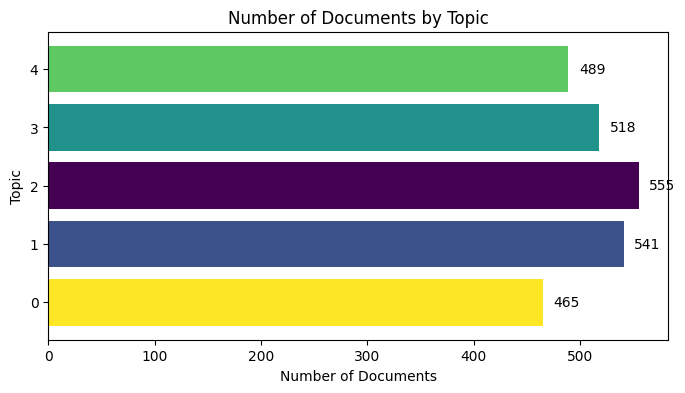

In [30]:
# Obtener el número de documentos por tema
doc_count_topic = df_filter['Dominant_Topic'].value_counts()

# Crear el histograma de barras horizontales con diferentes colores
plt.figure(figsize=(8, 4))
colors = plt.cm.viridis(np.linspace(0, 1, len(doc_count_topic)))
bars = plt.barh(doc_count_topic.index, doc_count_topic.values, color=colors)
plt.title("Number of Documents by Topic")
plt.xlabel("Number of Documents")
plt.ylabel("Topic")
plt.grid(False)  # Desactivar cuadrícula

# Agregar el número de documentos junto a cada barra
for bar, doc_count in zip(bars, doc_count_topic.values):
    plt.text(bar.get_width() + 10, bar.get_y() + bar.get_height()/2, str(doc_count), va='center', color='black')

plt.show()

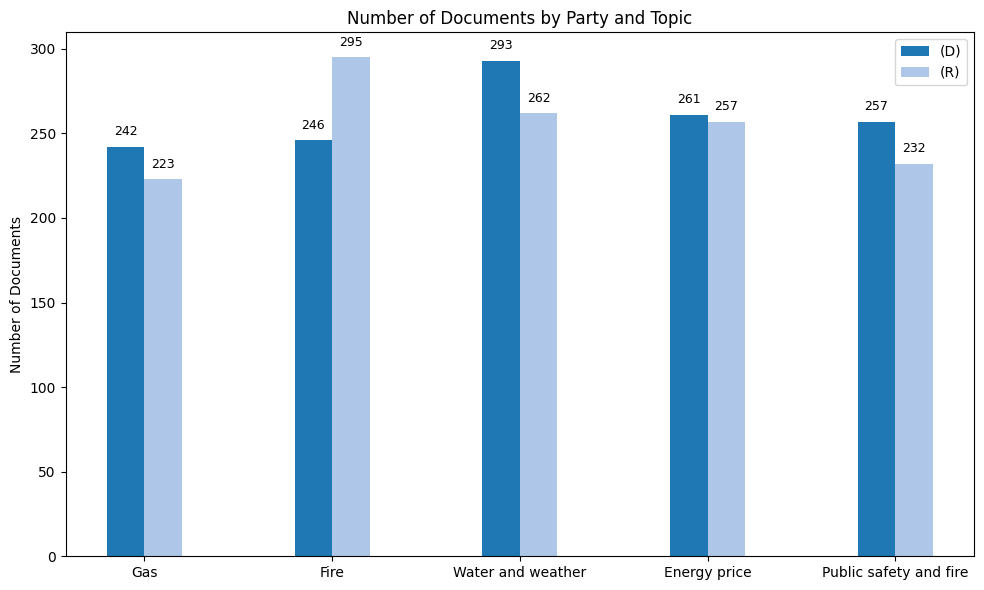

In [31]:
# Definir las etiquetas personalizadas para los temas
topic_labels = {
    0: "Water and weather",
    1: "Gas",
    2: "Energy price",
    3: "Public safety and fire",
    4: "Fire"
    # Define las etiquetas para los otros temas aquí
}

# Obtener el número de documentos por tema, agrupados por partido
doc_count_party_topic = df_filter.groupby(['party', 'Dominant_Topic']).size().unstack()

# Obtener los temas y partidos
topics = df_filter['Dominant_Topic'].unique()
parties = df_filter['party'].unique()

# Crear el histograma de barras agrupadas por partido
plt.figure(figsize=(10, 6))
bar_width = 0.2  # Ancho de las barras

# Recorrer cada partido y crear las barras para cada tema
for i, party in enumerate(parties):
    # Obtener los valores de recuento de documentos por tema para el partido actual
    party_values = doc_count_party_topic.loc[party].values

    # Calcular las posiciones de las barras para el partido actual
    party_positions = np.arange(len(party_values)) + i * bar_width

    # Crear las barras para el partido actual
    plt.bar(party_positions, party_values, width=bar_width, color=plt.cm.tab20(i), label=party)

    # Agregar etiquetas con los conteos en cada barra
    for j, value in enumerate(party_values):
        plt.text(party_positions[j], value + 5, str(value), ha='center', va='bottom', fontsize=9)
           

plt.title("Number of Documents by Party and Topic")
#plt.xlabel("Topic")
plt.ylabel("Number of Documents")

# Usar las etiquetas personalizadas en el eje x
plt.xticks(np.arange(len(topics)) + (len(parties) - 1) * bar_width / 2, [topic_labels[t] for t in topics])

plt.grid(False) 
plt.legend()
plt.tight_layout()
plt.show()


## Coherence

In [32]:
from gensim.models import CoherenceModel

In [33]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_texts_bigram, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.5555873010115638


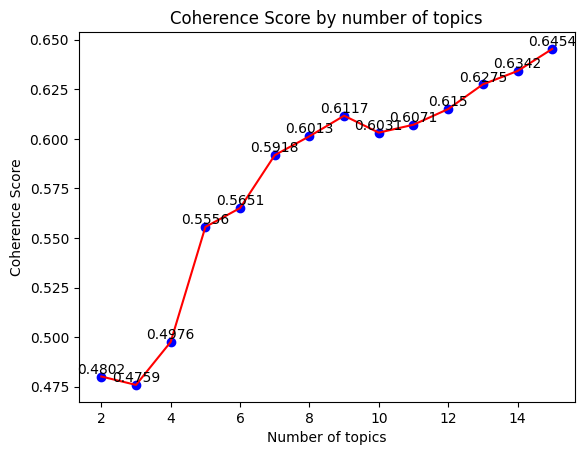

In [34]:
# list of coherence scores
coherence_scores = []

# number of topics range
min_topics = 2
max_topics = 15

# support function
for num_topics in range(min_topics, max_topics+1):
    # Entrenar el modelo LDA con el número de topics actual
    lda_model = gensim.models.LdaModel(corpus=corpus_tfidf,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       alpha='auto', eval_every=100,
                                       random_state=123)
    # Coherence Score calculation
    coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_texts_bigram, dictionary=id2word, coherence='c_v')
    try:
        coherence_score = coherence_model_lda.get_coherence()
    except Exception as e:
        coherence_score = np.nan
    
    # Coherence Score storage
    coherence_scores.append(coherence_score)

    # topic number vs coherence score
    if np.isfinite(coherence_score):
        plt.scatter(num_topics, coherence_score, color='blue')
        plt.text(num_topics, coherence_score, round(coherence_score, 4), ha='center', va='bottom')

# graph topic number vs coherence score
plt.plot(range(min_topics, max_topics+1), coherence_scores, color='red')
plt.xlabel("Number of topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score by number of topics")
plt.show()